# Rewrite of the plotting nonsense

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import cycle
import traceback

from glob import glob
from pathlib import Path
import os
import re
import sys
from tqdm import tqdm

sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io        import df_writer
from invisible_cities.io.dst_io        import load_dst

from invisible_cities.cities.beersheba import cut_over_Q
from invisible_cities.cities.beersheba import drop_isolated 
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db import DataPMT, DataSiPM
from invisible_cities.reco.peak_functions import rebin_times_and_waveforms


In [2]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle("rebinned in Z")
    plt.show(fig)



# load in the data

In [8]:
low_thr_files = glob('low_thr_10022026/*000[0-9]*')
low_thr_files  = sorted(low_thr_files, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

low_thr_files_pmap = glob('low_thr_10022026_pmap/*000[0-9]*')
low_thr_files_pmap  = sorted(low_thr_files_pmap, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

In [9]:
# load the old db
db = pd.read_csv('ChannelPosition_backup.csv')

In [10]:
# list of evts
#evts = [177, 219, 737, 842, 849, 954, 1045, 1087, 1094]
evts = [86, 289, 310, 443]

In [39]:
thr_EOI = []
thr_EOI_pmap = []
for thr_file, pmap_file in tqdm(zip(low_thr_files, low_thr_files_pmap)):

    df_thr = load_dst(thr_file, 'RECO', 'Events')
    df_thr_pmap = load_pmaps(pmap_file)

    df_thr = df_thr[df_thr.event.isin(evts)]
    df_thr_pmap = {f'{x}' : df_thr_pmap[x] for x in df_thr_pmap if x in evts}
    
    thr_EOI.append(df_thr)
    thr_EOI_pmap.append(df_thr_pmap)
    # all our events are in the first file, and I'm too lazy to do this any better
    break
thr_EOI = pd.concat(thr_EOI)

0it [00:59, ?it/s]


In [21]:
# kill the screamer
print(thr_EOI.shape[0])
thr_EOI = thr_EOI[~((thr_EOI.X == 243.225) & (thr_EOI.Y == -340.975))]
print(thr_EOI.shape[0])


1225728
1225386


## define cut_over_Q and drop_isolated object

In [22]:
q_thr     = 7
drop_dist = [15.55, 15.55]

cut_sensors   = cut_over_Q(q_thr, ['E', 'Ec'])
drop_sensors  = drop_isolated(drop_dist, ['E', 'Ec'])


## select event of interest

In [23]:
evt = 289

No thresholds


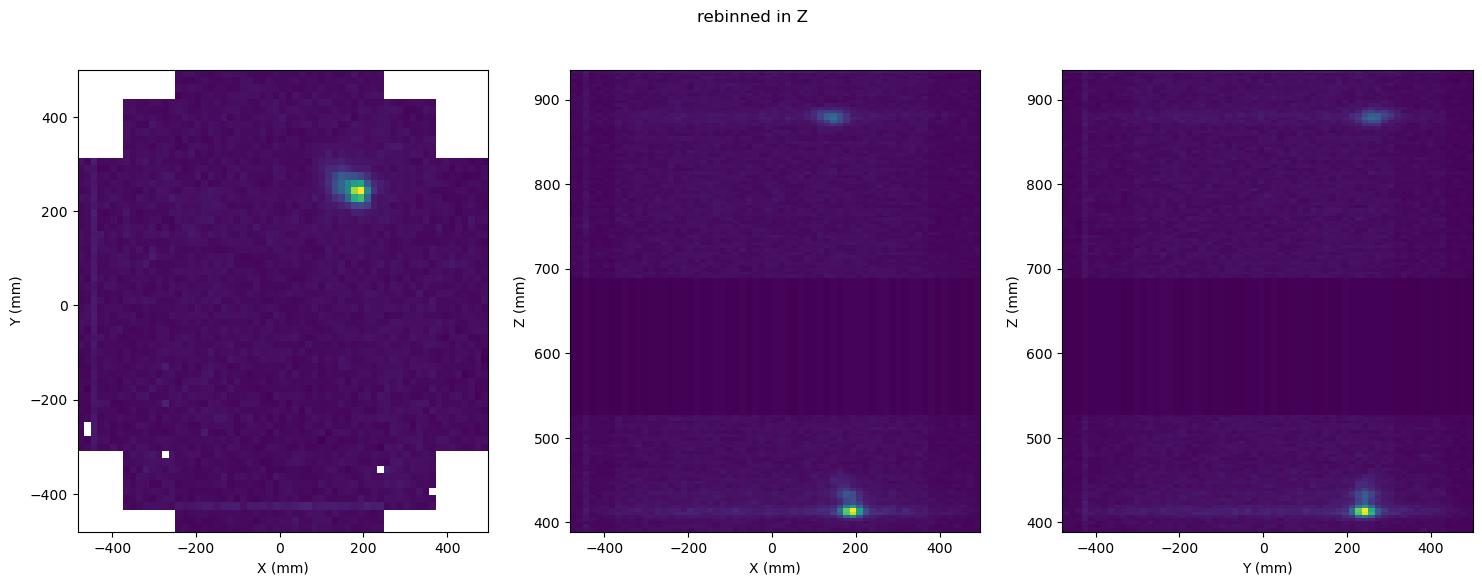

No thresholds with cut at 7


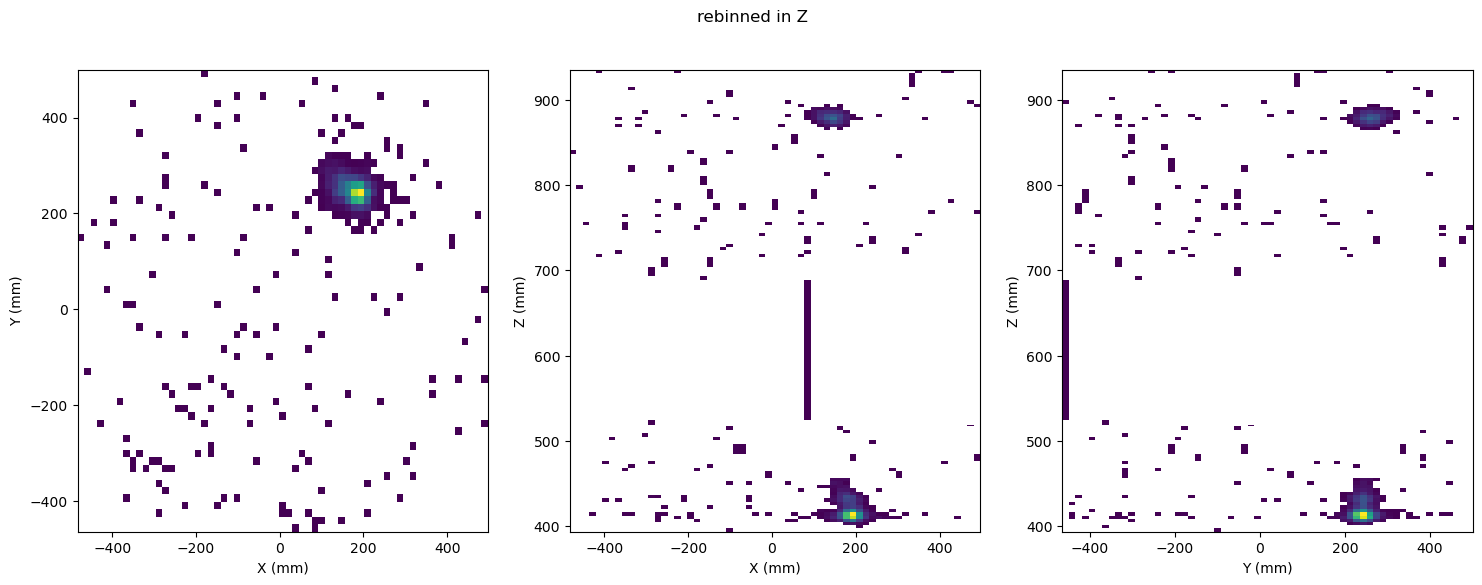

In [24]:
# plot the difference
thr_EOI_evt = thr_EOI[thr_EOI.event == evt]
print('No thresholds')
raw_plotter(thr_EOI_evt, evt)
print(f'No thresholds with cut at {q_thr}')
raw_plotter(cut_sensors(thr_EOI_evt), evt)

## select a sipm xy of interest

In [27]:
thr_list = list(zip(thr_EOI_evt.X.values, thr_EOI_evt.Y.values))

# arbitrary index
xy_index = 2720

x_val = thr_list[xy_index][0]
y_val = thr_list[xy_index][1]
print(x_val, y_val)

196.575 276.025


296.4894620999694


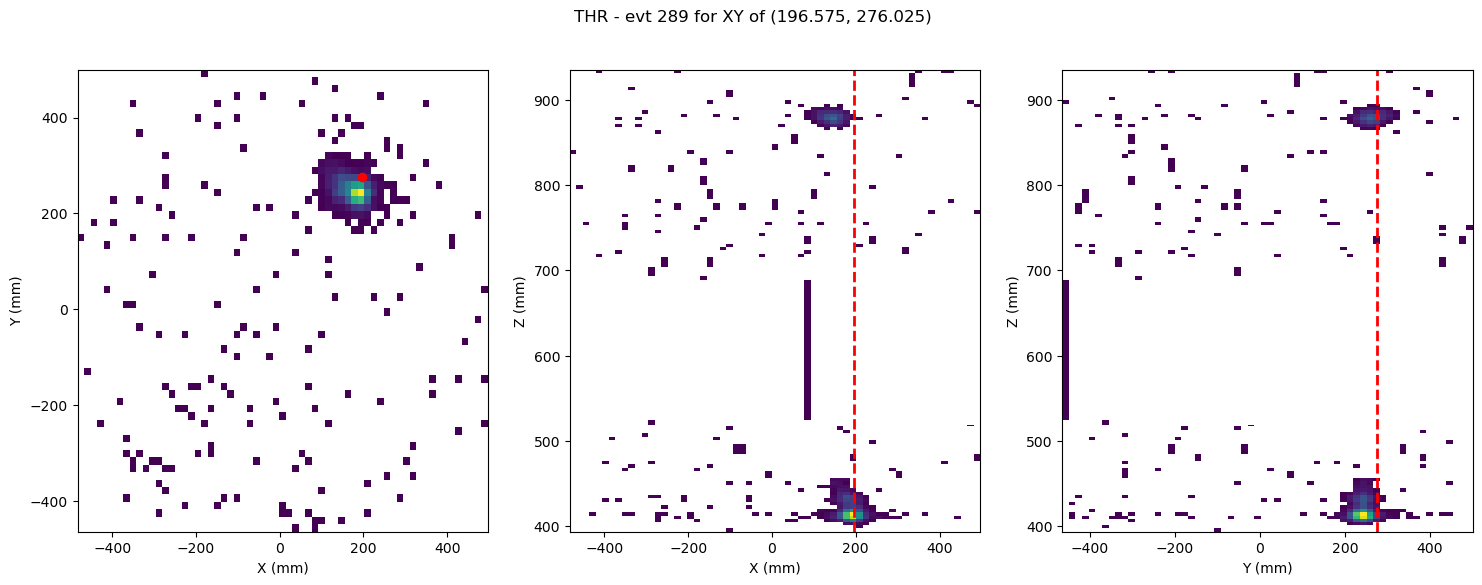

In [28]:
# visualise xy choice
df_thr_xy = thr_EOI_evt[(thr_EOI_evt.X == x_val) & (thr_EOI_evt.Y == y_val)]
print(df_thr_xy.Q.sum())

q = cut_sensors(thr_EOI_evt)
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.sort(q.Z.unique())

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[0].scatter(x_val, y_val, c = 'red')

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[1].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 

fig.suptitle(f"THR - evt {q.event.unique()[0]} for XY of {x_val, y_val}")
plt.show(fig)


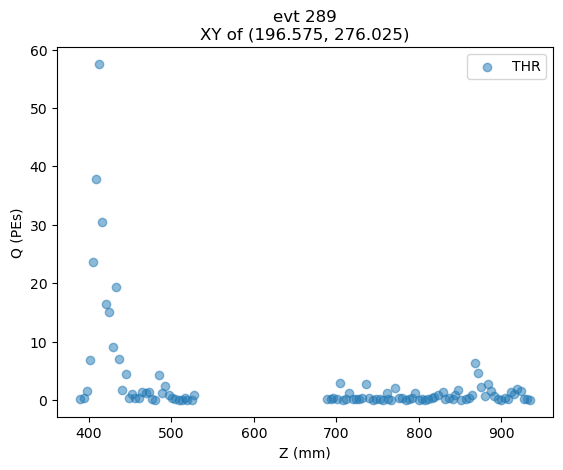

In [29]:
# z axis histo
plt.scatter(df_thr_xy.Z.values, df_thr_xy.Q.values, label = 'THR', alpha = 0.5)
plt.xlabel('Z (mm)')
plt.ylabel('Q (PEs)')
plt.title(f'evt {df_thr_xy.event.unique()[0]}\nXY of {x_val, y_val}')
#plt.xlim([590, 650])
plt.legend()
plt.show()


## extract db index

In [30]:
sens_id = db[(db.X == x_val) & (db.Y == y_val)].index[0]
print(sens_id)

2781


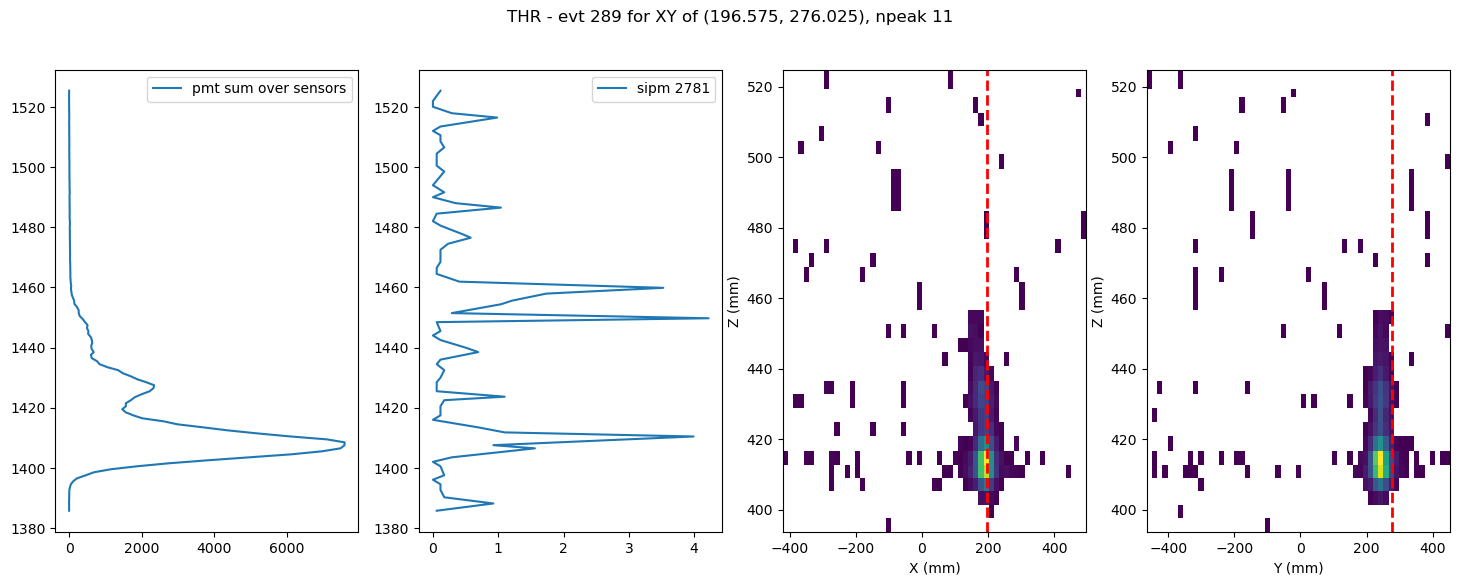

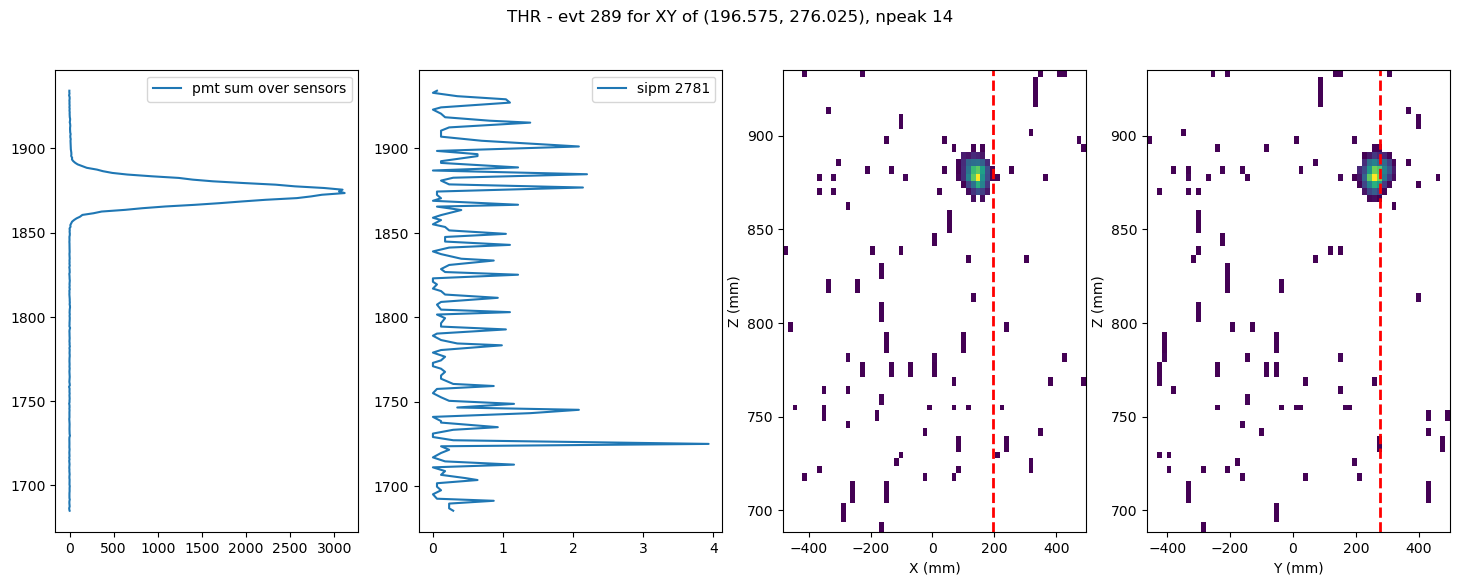

In [86]:
# plot each npeak wrt its sipms and pmts
for npeak, evt_hits in q.groupby('npeak'):
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    # binning
    xx = np.arange(evt_hits.X.min(), evt_hits.X.max() + pitch, pitch)
    yy = np.arange(evt_hits.Y.min(), evt_hits.Y.max() + pitch, pitch)
    zz = np.sort(evt_hits.Z.unique())

    # rebin
    times_mod = df_thr_pmap[str(evt)].s2s[npeak].times/1e3
    wf_mod    = df_thr_pmap[str(evt)].s2s[npeak].sipms.waveform(sensor_id = sens_id)
    width_mod = np.zeros(len(wf_mod))
    times_mod, width_mod, wf_mod = rebin_times_and_waveforms(times_mod, width_mod, wf_mod[np.newaxis])
    
    
    
    axes[1].plot(wf_mod[0], times_mod, label = f'sipm {sens_id}')
    axes[1].legend()
    #axes[1].plot(df_thr_pmap[evt].s2s[npeak].sipms.waveform(sensor_id = sens_id), df_thr_pmap[evt].s2s[npeak].times/1e3, label = 'pmt sum over sensors')
    
    #axes[1].scatter(x_val, y_val, c = 'red')

    axes[2].hist2d(evt_hits.X, evt_hits.Z, bins=[xx, zz], weights=evt_hits.Q, cmin=0.0001);
    axes[2].set_xlabel('X (mm)');
    axes[2].set_ylabel('Z (mm)');

    axes[2].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

    axes[3].hist2d(evt_hits.Y, evt_hits.Z, bins=[yy, zz], weights=evt_hits.Q, cmin=0.0001);
    axes[3].set_xlabel('Y (mm)');
    axes[3].set_ylabel('Z (mm)');
    axes[3].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 
    # extract the s2 related to the hits, plot on the 0th axis
    axes[0].plot(df_thr_pmap[str(evt)].s2s[npeak].pmts.sum_over_sensors, df_thr_pmap[str(evt)].s2s[npeak].times/1e3, label = 'pmt sum over sensors')
    axes[0].legend()
    
# visualise the differing s2s

#for enum, (minima, maxima) in enumerate(zip(mins, maxes)):
#    print(f'Min max bands of:\n{minima}, {maxima}')
#    col = next(colour_cycle)
#    axes[1].axhspan(minima, maxima, alpha=0.3, color = col, label = s2s_of_interest[enum])
#    axes[2].axhspan(minima, maxima, alpha=0.3, color = col)

    
    fig.suptitle(f"THR - evt {evt_hits.event.unique()[0]} for XY of {x_val, y_val}, npeak {npeak}")
    plt.show(fig)
